<b>Nome:</b> Victor Augusto Kich 

<b>Matricula:</b> 201721736

<center><h2>CONVERSÃO ADC E DAC DE SINAL</h2></center>
</br>

Realizar uma regeneração de um sinal analógico de uma frequência que pode ser variável de 1 a 
4kHz. Este sinal original é digitalizado e posteriormente convertido a sinal analógico novamente. 
Os sinais tem que ser idênticos e devem ter um atraso mínimo de fase. O sistema deve obter os 
seguintes requisitos: 

• O sinal de entrada deve ser de 2Vp-p 

• O sinal de saída deve ser de 12Vp-p 

• Sinal de teste pode ser senoidal e variar nas frequências especificadas 

• Dispor de proteção contra inversão de polaridade; 

• Utilizar um Arduino ou sistema digitalizador a conveniência; 

Para editar e utilizar esse arquivo instale suas dependências utilizando as seguintes linhas de código:

```shell
sudo apt install libngspice0-dev
```

```shell
pip3 install skidl pyspice
```

<p align="center"> 
  <img src="adc2dac.png" alt="ADC2DAC"/>
</p>  

Para a realização desse trabalho foram usados os simuladores  <a href="https://pypi.org/project/PySpice/">PySpice</a> e <a href="https://pypi.org/project/skidl/">SKiDL</a>. A linguagem de programação utilizada para a configuração e análise da simulação foi o <a href="https://www.python.org/downloads/release/python-383/Python">Python 3.8.3</a>. A interface para a realização do trabalho foi o <a href="https://jupyter.org/Jupyter">Jupyter Notebook</a>.

In [1]:
from skidl import *

<p align="center"> 
  <img src="dataflow.png" alt="DataFlow"/>
</p>  

In [2]:
# Load the package for drawing graphs.
import matplotlib.pyplot as plt
# Omit the following line if you're not using a Jupyter notebook.
%matplotlib inline

# Load the SKiDL + PySpice packages and initialize them for doing circuit simulations.
from skidl.pyspice import *
import numpy as np
import pandas as pd
from scipy import signal

In [3]:
reset()  # Clear out the existing circuitry

# Sinusoidal voltage source.
vin = sinev(offset=0.0 @ u_V, amplitude=1.0 @ u_V, frequency=1 @u_kHz)

# Creating an XSPICE part from the pyspice library.
adc = Part("pyspice", "A", io="anlg_in[], dig_out[]",  # Two vector I/O ports in a string.
    model=XspiceModel(
        "adc",  # The name assigned to this particular model instance.
        "adc_bridge",  # The name of the XSPICE part associated with this model.
        # The rest of the arguments are keyword parameters for the model.
        in_low=0.0 @ u_V,
        in_high=12.0 @ u_V,
        rise_delay=0.001 @ u_ms,
        fall_delay=0.001 @ u_ms,
    ),
    tool=SKIDL
)

# Creating an XSPICE part using the SPICE abbreviation 'A'.
buf = A(io="buf_in, buf_out",  # Two scalar I/O ports in a string.
    model=XspiceModel(
        "buf",
        "d_buffer",
        rise_delay=0.001 @ u_ms,
        fall_delay=0.001 @ u_ms,
        input_load=0.001 @ u_ms
    ),
)

# Creating an XSPICE part using the XSPICE alias.
dac = XSPICE(io=["dig_in[]", "anlg_out[]"],  # Two vector ports in an array.
    model=XspiceModel("dac", "dac_bridge", out_low=0.0 @ u_V, out_high=12.0 @ u_V),
)

r = R(value=1 @ u_kOhm)  # Load resistor.

# Connections: sine wave -> ADC -> buffer -> DAC.
vin["p, n"] += adc["anlg_in"][0], gnd  # Attach to first pin in ADC anlg_in vector of pins.
adc["dig_out"][0] += buf["buf_in"]  # Attach first pin of ADC dig_out vector to buffer.
buf["buf_out"] += dac["dig_in"][0]  # Attach buffer output to first pin of DAC dig_in vector of pins.
r["p,n"] += dac["anlg_out"][0], gnd  # Attach first pin of DAC anlg_out vector to load resistor.

circ = generate_netlist(libs="SpiceLib")
print(circ)
sim = circ.simulator()
waveforms = sim.transient(step_time=0.001 @ u_ms, end_time=2 @ u_ms)
time = waveforms.time
vin = waveforms[node(vin["p"])]
vout = waveforms[node(r["p"])]

vin = np.array(vin)
vout = np.array(vout)

.title 
V1 N_1 0 DC 0V AC 1V SIN(0.0V 1.0V 1kHz 0s 0Hz)
A1 [N_1] [N_2] adc
A2 N_2 N_3 buf
A3 [N_3] [N_4] dac
R1 N_4 0 1kOhm
.model adc adc_bridge (fall_delay=0.001ms in_high=12.0V in_low=0.0V rise_delay=0.001ms)
.model buf d_buffer (fall_delay=0.001ms input_load=0.001ms rise_delay=0.001ms)
.model dac dac_bridge (out_high=12.0V out_low=0.0V)




No errors or warnings found during netlist generation.



In [4]:
d = {'Input': vin, 'Output': vout}
df = pd.DataFrame(data=d)
print('Resultados coletados da simulação:')
print(df)

Resultados coletados da simulação:
             Input  Output
0     0.000000e+00     0.0
1     6.283185e-05     0.0
2     1.256637e-04     0.0
3     2.513274e-04     0.0
4     5.026548e-04     0.0
...            ...     ...
2076 -1.889503e-02     0.0
2077 -1.261263e-02     0.0
2078 -6.329739e-03     0.0
2079 -4.659614e-05     0.0
2080 -4.898587e-16     0.0

[2081 rows x 2 columns]


<p align="center"> 
  <img src="diagrama.png" alt="Diagrama de conversão ADC2DAC"/>
</p>  

<center><h3> Sinal Analógico na entrada do conversor ADC </h3></center>

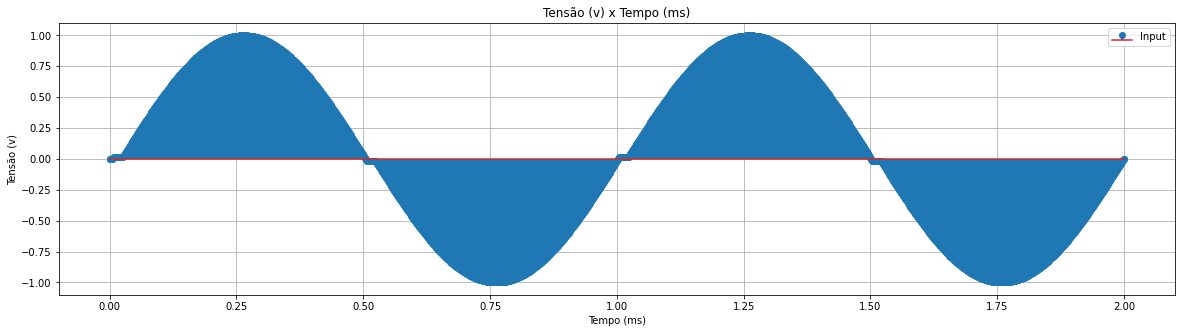

In [5]:
x = np.linspace(0, 2, len(vin))

fig, axs = plt.subplots(1, figsize=(20, 5))
axs.stem(x, vin, label='Input')
axs.set_xlabel('Tempo (ms)')
axs.set_ylabel('Tensão (v)')
plt.title('Tensão (v) x Tempo (ms)')
plt.legend()
plt.grid()
plt.show()

<center><h3> Sinal Analógico na saída do conversor DAC </h3></center>

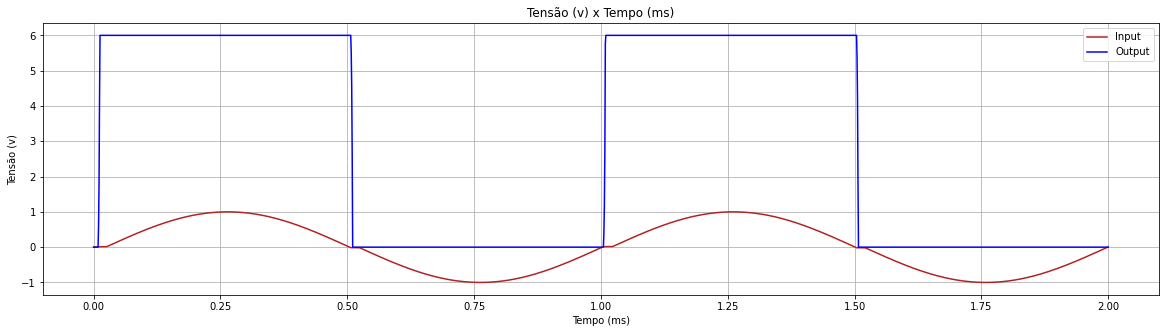

In [6]:
fig, axs = plt.subplots(1, figsize=(20, 5))
axs.plot(x, vin, color='firebrick', label='Input')
axs.plot(x, vout, color='blue', label='Output')
axs.set_xlabel('Tempo (ms)')
axs.set_ylabel('Tensão (v)')
plt.title('Tensão (v) x Tempo (ms)')
plt.legend()
plt.grid()
plt.show()

<center><h3>AC Coupled Amplifier</h3></center>

<p align="center"> 
  <img src="ac-coupled-amplifier.png" alt="AC Coupled Amplifier" width=400 height=300/>
</p>

In [7]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

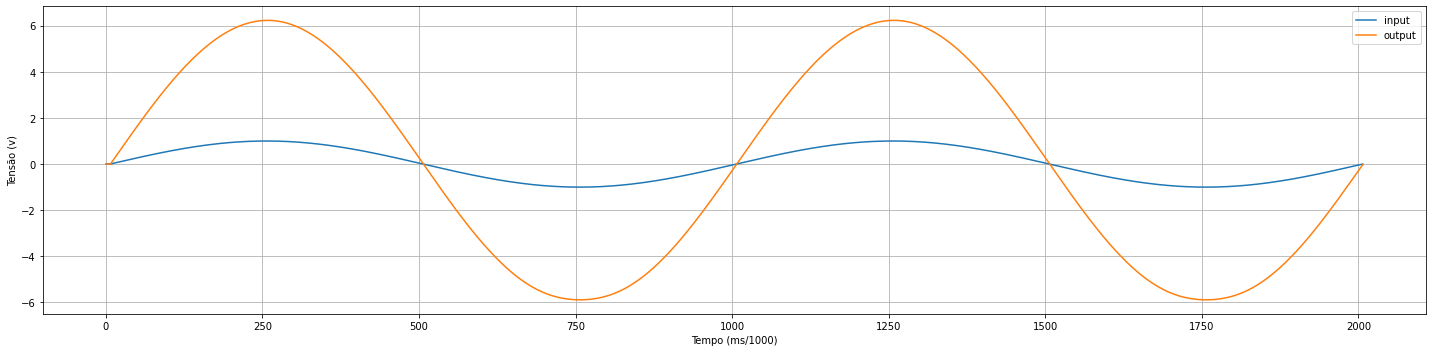

In [8]:
circuit = Circuit('Transistor')

circuit.V('power', 5, circuit.gnd, 15@u_V)
source = circuit.SinusoidalVoltageSource('in', 'in', circuit.gnd, amplitude=1@u_V, frequency=1@u_kHz)
circuit.C(1, 'in', 2, 10@u_uF)
circuit.R(1, 5, 2, 145@u_kΩ)
circuit.R(2, 2, 0, 20@u_kΩ)
circuit.R('C', 5, 4, 13@u_kΩ)
circuit.BJT(1, 4, 2, 3, model='bjt')
circuit.model('bjt', 'npn', bf=100, cjc=pico(100), rb=80)
circuit.R('E', 3, 0, 2@u_kΩ)
circuit.C(2, 4, 'out', 10@u_uF)
circuit.R('Load', 'out', 0, 1@u_MΩ)

figure, ax = plt.subplots(figsize=(20, 5))

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=source.period/1000, end_time=source.period*2)
signal_input = analysis['in']
signal_output = -analysis.out

ax.set_title('')
ax.set_xlabel('Tempo (ms/1000)')
ax.set_ylabel('Tensão (v)')
ax.grid()
ax.plot(signal_input)
ax.plot(signal_output)
ax.legend(('input', 'output'))

plt.tight_layout()
plt.show()


<center><h3>Simulação Numérica</h3></center>

<center>Simulação dos processo de amostragem e reconstrução do sinal utilizando filtro passa-baixas ideal.</center>

In [9]:
def amostragem(sig_in, td, ts):
    if int(ts/td) == ts/td:
        s_out = np.zeros(len(sig_in))
        for i in range(0,len(sig_in), int(ts/td)):
            s_out[i] = sig_in[i]
    else:
        s_out = np.array([])
    return s_out

<center><h3>Amostragem</h3></center>

<p align="center"> 
  <img src="analog2digital.gif" alt="Analog to Digital"/>
</p>  

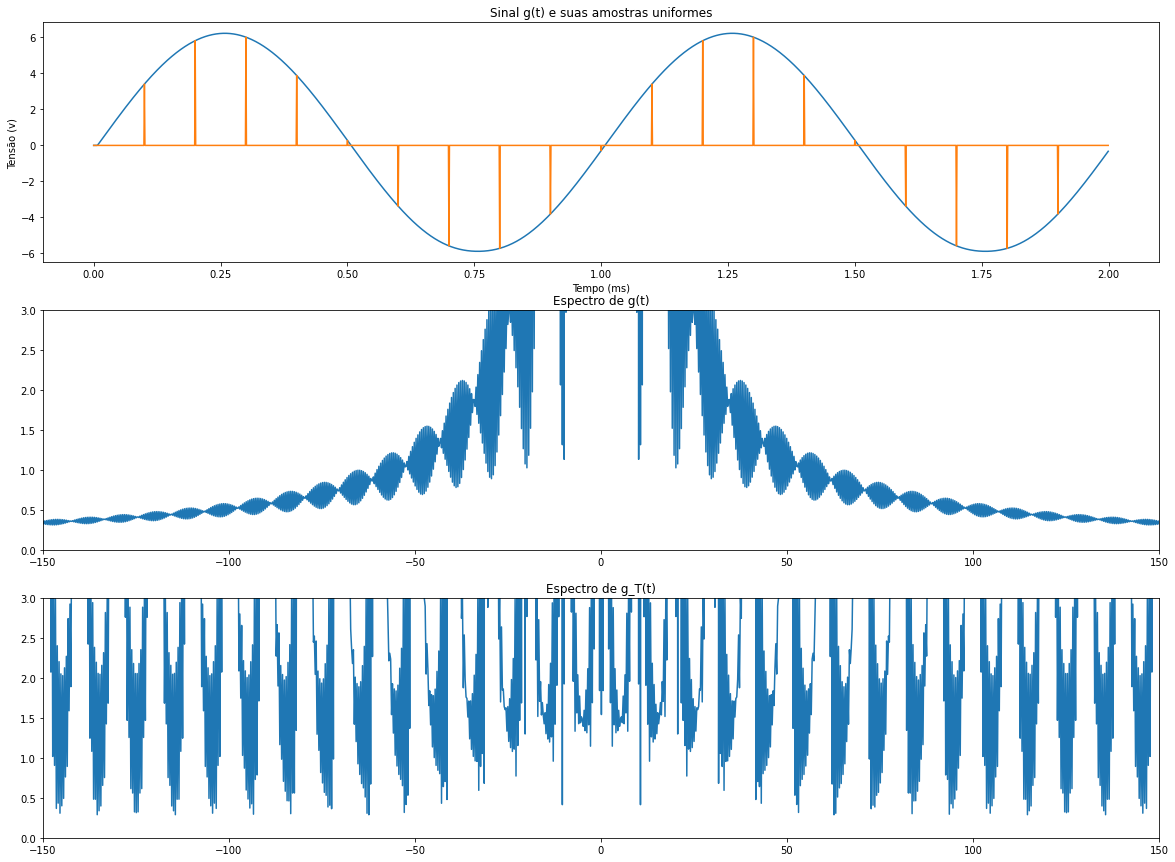

In [10]:
# Exemplo de amostragem e quantização
td = 0.001  # Intervalo entre os pontos do sinal "analógico"
t = np.arange(0, 2, td)  # Intervalo de 2 ms

# Equivalente a uma função np.sin(2*np.pi*t)*2  
xsig = signal_output[:2000]  # seno de 1kHz com amplitude de 6v
Lsig = len(xsig)

ts = 0.1  # Taxa de amostragem
fator = ts / td
# Envia o sinal a um amostrador
s_out = amostragem(xsig, td, ts)

# Calcula a transformada de Fourier
Lfft = int(2**np.ceil(np.log2(Lsig)+1))
Fmax = 1 / (2*td)
Faxis = np.linspace(-Fmax, Fmax, Lfft)
Xsig = np.fft.fftshift(np.fft.fft(xsig, Lfft))
S_out = np.fft.fftshift(np.fft.fft(s_out, Lfft))

# Traça gráfico do sinal original e do sinal amostrado nos domínios do tempo e da frequência
fig, axs = plt.subplots(3, figsize=(20, 15))
axs[0].plot(t, xsig)
axs[0].plot(t, s_out[:Lsig])
axs[0].set_title('Sinal g(t) e suas amostras uniformes')
axs[0].set_xlabel('Tempo (ms)')
axs[0].set_ylabel('Tensão (v)')

axs[1].plot(Faxis, abs(Xsig))
axs[1].axis([-150, 150, 0, 300/fator])
axs[1].set_title('Espectro de g(t)')

axs[2].plot(Faxis, abs(S_out))
axs[2].axis([-150, 150, 0, 300/fator])
axs[2].set_title('Espectro de g_T(t)')
plt.show()

<center><h3>Transformada Inversa de Fourier</h3></center>

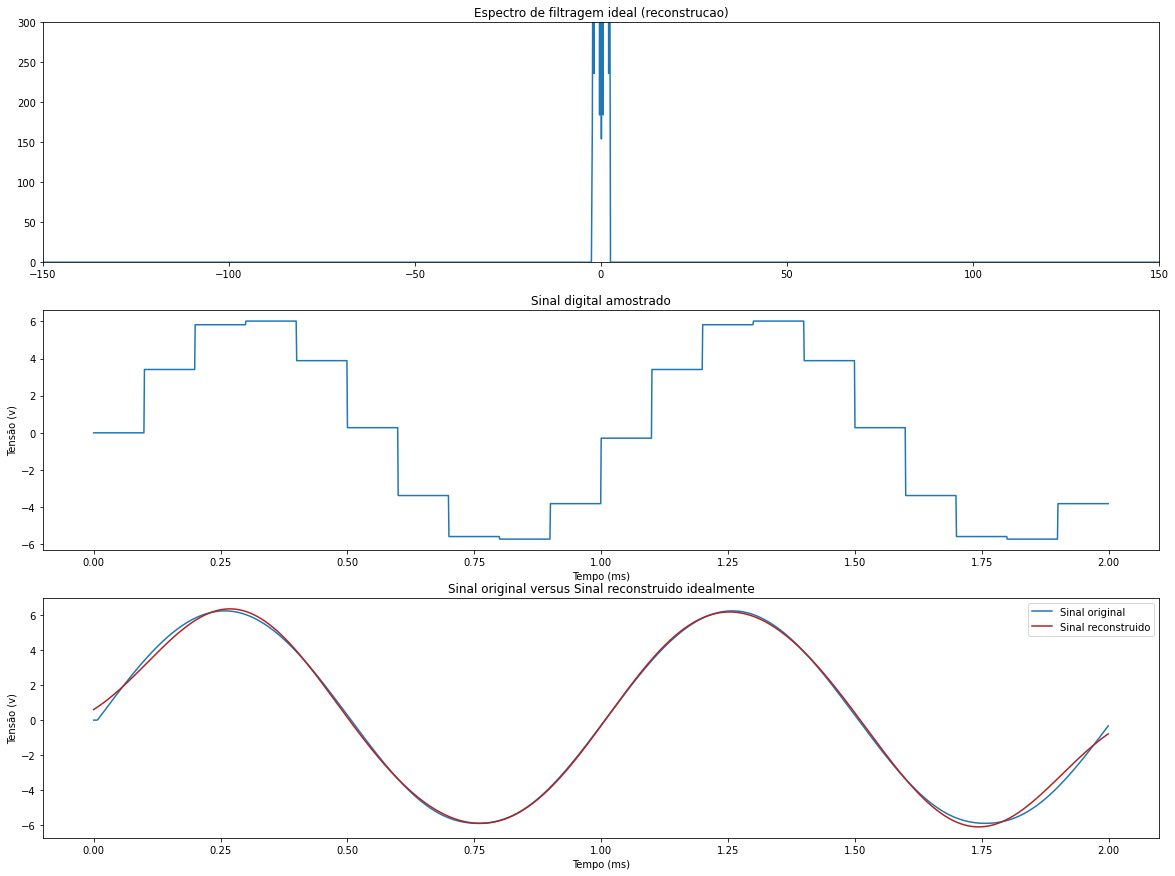

In [11]:
# Calcula o sinal reconstruído a partir de amostragem ideal e LPF (filtro passa-baixas) ideal
# Máxima largura do LPF é igual a BW=floor((Lfft/Nfactor)/2)
BW = 10  # Largura de banda
H_lpf = np.zeros(Lfft)
H_lpf[int(Lfft/2-BW):int(Lfft/2+BW)] = 1  # LPF ideal
S_recv = fator * S_out * H_lpf  # Filtragem ideal
s_recv = np.fft.ifft(np.fft.fftshift(S_recv))  # Domínio da freq. reconstruído
s_recv = s_recv[:Lsig]  # Domíonio do tempo reconstruído

d_out = list()
last = 0
for i in range(s_out[:Lsig].size):
    if s_out[i]:
        last = s_out[i]
    d_out.append(last)
d_out = np.array(d_out)

# Traça o gráfico do sinal reconstruído idealmente nos domínios do tempo e da frequência
fig, axs = plt.subplots(3, figsize=(20, 15))
axs[0].plot(Faxis, abs(S_recv))
axs[0].axis([-150, 150, 0, 300])
axs[0].set_title('Espectro de filtragem ideal (reconstrucao)')

axs[1].plot(t, d_out, label="Sinal digital")
axs[1].set_title("Sinal digital amostrado")
axs[1].set_xlabel('Tempo (ms)')
axs[1].set_ylabel('Tensão (v)')

axs[2].plot(t, xsig,label="Sinal original")
axs[2].plot(t, s_recv[:Lsig].real, label="Sinal reconstruido", c='firebrick')
axs[2].set_title("Sinal original versus Sinal reconstruido idealmente")
axs[2].set_xlabel('Tempo (ms)')
axs[2].set_ylabel('Tensão (v)')
plt.legend()
plt.show()